## Setup

Requirements:


In [ ]:
#Load Packages
import pandas as pd
import numpy as np
import patsy as pt
import plotly.express as px
import nbformat
import plotly as py
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import statsmodels.api as sm
import statsmodels.tsa.stattools as st


In [38]:
#Load Data
data = pd.read_csv("data/amazon-purchases.csv")
survey_data = pd.read_csv("data/survey.csv")

# Data Pre-Processing

In [39]:
#Add a prime purchase column to the data

#Create a list with prime days inside it
prime_days = ["2022-07-12", "2022-07-13", "2021-06-21", "2021-06-22", "2020-10-13", "2020-10-14", "2019-07-15", "2019-07-16", "2018-07-17", "2018-07-18",]

prime_purchase = []
for i in data["Order Date"]:
    if i in prime_days:
        prime_purchase.append(1)
    else:
        prime_purchase.append(0)
data["Prime Purchase"] = prime_purchase

In [40]:
#Use prime purchase data to create a prime day customer list
prime_day_customer = []
for i in range(len(data)):
    if data["Prime Purchase"][i] == 1:
        prime_day_customer.append(data["Survey ResponseID"][i])
prime_day_customer = set(prime_day_customer)

prime_customer = []
for i in data["Survey ResponseID"]:
    if i in prime_day_customer:
        prime_customer.append(1)
    else:
        prime_customer.append(0)

data["Prime Customer"] = prime_customer

In [41]:
# Merge the purchase data with customer surveys on 'Survey ResponseID'
merged_data = pd.merge(data, survey_data, on='Survey ResponseID', how='inner')

# Display the first few rows of the merged dataframe
print(merged_data.shape, data.shape, survey_data.shape)

(1850717, 32) (1850717, 10) (5027, 23)


In [42]:
subset_data = merged_data[(merged_data['Q-demos-gender'] == 'Female') & (merged_data['Q-demos-age'] != '65 and older') & (merged_data['Prime Customer'] == 1) & (merged_data['Q-amazon-use-howmany']=='1 (just me!)')]

In [43]:
#Calculate Revenue to use in forecast
subset_data['Revenue'] = subset_data['Quantity'] * subset_data['Purchase Price Per Unit']

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\2637245334.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
subset_data.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue
140,2018-01-18,17.16,1.0,PA,"NOW Foods, Certified Organic Better Stevia, Ex...",B005F9XFN0,SUGAR_SUBSTITUTE,R_037XK72IZBJyF69,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,17.16
141,2018-01-18,6.49,1.0,PA,"F.M. Brown'S Encore Parakeet Food, 5-Pound",B000HHSHZG,PET_FOOD,R_037XK72IZBJyF69,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,6.49
142,2018-01-18,14.99,1.0,PA,COTTON CRAFT - Scandia Stripe 12 Pack - Pure C...,B014V1IYEM,TOWEL,R_037XK72IZBJyF69,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,14.99
143,2018-01-18,12.99,1.0,PA,"XREXS 4 Channels Digital Kitchen Timer Clock, ...",B01K4JKFK6,TIMER,R_037XK72IZBJyF69,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.99
144,2018-01-18,12.87,1.0,PA,Premium Wrist Rests for Keyboard and Mouse Pad...,B01A92ETXM,WRIST_REST,R_037XK72IZBJyF69,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.87


Data exploration

In [45]:
unique_responses_by_gender = merged_data.groupby('Q-demos-gender')['Survey ResponseID'].nunique()
print(unique_responses_by_gender)

Q-demos-gender
Female               2589
Male                 2311
Other                 116
Prefer not to say      11
Name: Survey ResponseID, dtype: int64


In [46]:
subset_data['Order Date'].max()
record = subset_data[merged_data['Order Date'] == subset_data['Order Date'].max()]
record

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\4112819008.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue
307061,2023-03-21,35.99,1.0,NJ,occer 12x25 Compact Binoculars with Clear Low ...,B0756BXDTX,BINOCULAR,R_1jUqdfR1Zz6mZMf,0,1,...,Yes,No,No,Moved place of residence,Yes if I get part of the profit,Yes if consumers get part of the profit,No,I don't know,Yes,35.99
307062,2023-03-21,5.49,1.0,NJ,Aquaphor Healing Ointment Advanced Therapy Ski...,B001IAG7G2,SKIN_MOISTURIZER,R_1jUqdfR1Zz6mZMf,0,1,...,Yes,No,No,Moved place of residence,Yes if I get part of the profit,Yes if consumers get part of the profit,No,I don't know,Yes,5.49
1710835,2023-03-21,12.99,1.0,NY,NeilMed Sinus Rinse All Natural Relief Premixe...,B00TU5P33K,MEDICATION,R_e8KTElZZLWryLWp,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,I don't know,I don't know,12.99


In [47]:
subset_data.columns

Index(['Order Date', 'Purchase Price Per Unit', 'Quantity',
       'Shipping Address State', 'Title', 'ASIN/ISBN (Product Code)',
       'Category', 'Survey ResponseID', 'Prime Purchase', 'Prime Customer',
       'Q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education',
       'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation',
       'Q-demos-state', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size',
       'Q-amazon-use-how-oft', 'Q-substance-use-cigarettes',
       'Q-substance-use-marijuana', 'Q-substance-use-alcohol',
       'Q-personal-diabetes', 'Q-personal-wheelchair', 'Q-life-changes',
       'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use',
       'Q-census-use', 'Q-research-society', 'Revenue'],
      dtype='object')

In [48]:
# Convert 'Order Date' to datetime
subset_data['Order Date'] = pd.to_datetime(subset_data['Order Date'])

# Group by 'Order Date' and sum the 'Purchase Price Per Unit'
transaction_totals = subset_data.groupby(['Order Date', 'Q-demos-gender'])['Purchase Price Per Unit'].sum().reset_index()

# Plot the time series
px.line(transaction_totals, x='Order Date', y='Purchase Price Per Unit', title='Transaction Totals Over Time')

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\758613859.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
subset_data['Year'] = subset_data['Order Date'].dt.year
subset_data['Month'] = subset_data['Order Date'].dt.month
subset_data['Day'] = subset_data['Order Date'].dt.day
subset_data['Day of Week'] = subset_data['Order Date'].dt.dayofweek

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [50]:
subset_data.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue,Year,Month,Day,Day of Week
140,2018-01-18,17.16,1.0,PA,"NOW Foods, Certified Organic Better Stevia, Ex...",B005F9XFN0,SUGAR_SUBSTITUTE,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,17.16,2018,1,18,3
141,2018-01-18,6.49,1.0,PA,"F.M. Brown'S Encore Parakeet Food, 5-Pound",B000HHSHZG,PET_FOOD,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,6.49,2018,1,18,3
142,2018-01-18,14.99,1.0,PA,COTTON CRAFT - Scandia Stripe 12 Pack - Pure C...,B014V1IYEM,TOWEL,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,14.99,2018,1,18,3
143,2018-01-18,12.99,1.0,PA,"XREXS 4 Channels Digital Kitchen Timer Clock, ...",B01K4JKFK6,TIMER,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.99,2018,1,18,3
144,2018-01-18,12.87,1.0,PA,Premium Wrist Rests for Keyboard and Mouse Pad...,B01A92ETXM,WRIST_REST,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.87,2018,1,18,3


# Clustering for Feature Selection

K-means for purchase quantity and purchase totals

In [51]:
#Group by survey response id and count the number of prime purchases and sum the price per unit
prime_users = subset_data.groupby("Survey ResponseID").agg({"Prime Purchase":"sum", "Purchase Price Per Unit":"sum"})
#Left join prime purchases with survey data
print(prime_users.shape)
#Rename 

(1000, 2)


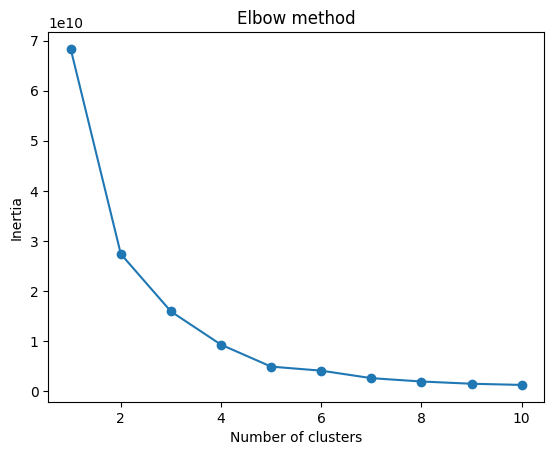

In [52]:
k_data = list(zip(prime_users['Prime Purchase'], prime_users['Purchase Price Per Unit']))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(k_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

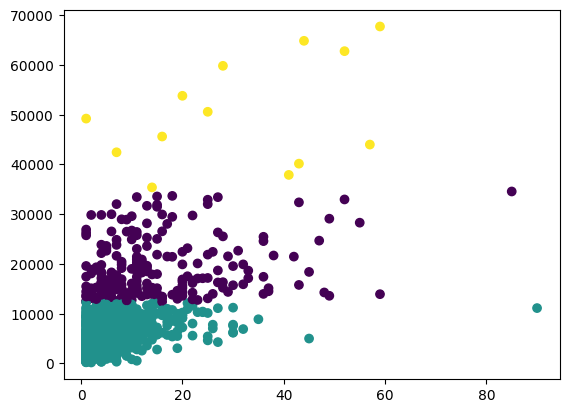

In [53]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(k_data)

plt.scatter(prime_users['Prime Purchase'], prime_users['Purchase Price Per Unit'], c=kmeans.labels_)
plt.show()

In [54]:
# Display the cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the labels assigned to each data point
print("Cluster Labels:")
print(kmeans.labels_)

prime_users['cluster'] = kmeans.labels_

Cluster Centers:
[[1.43304721e+01 1.88143265e+04]
 [5.90848806e+00 5.76666634e+03]
 [3.13076923e+01 5.03216477e+04]]
Cluster Labels:
[0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0
 1 1 2 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 2 2 1 1 0 1 1
 1 1 1 0 0 1 1 1 1 1 2 1 0 1 1 1 1 2 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0
 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 2 1 2 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1

In [55]:
# Merge the subset_data with prime_users to map the cluster labels
subset_data_with_clusters = pd.merge(subset_data, prime_users[['cluster']], on='Survey ResponseID', how='left')

# Display the first few rows of the resulting dataframe
subset_data_with_clusters.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue,Year,Month,Day,Day of Week,cluster
0,2018-01-18,17.16,1.0,PA,"NOW Foods, Certified Organic Better Stevia, Ex...",B005F9XFN0,SUGAR_SUBSTITUTE,R_037XK72IZBJyF69,0,1,...,Yes if consumers get part of the profit,I don't know,No,Yes,17.16,2018,1,18,3,0
1,2018-01-18,6.49,1.0,PA,"F.M. Brown'S Encore Parakeet Food, 5-Pound",B000HHSHZG,PET_FOOD,R_037XK72IZBJyF69,0,1,...,Yes if consumers get part of the profit,I don't know,No,Yes,6.49,2018,1,18,3,0
2,2018-01-18,14.99,1.0,PA,COTTON CRAFT - Scandia Stripe 12 Pack - Pure C...,B014V1IYEM,TOWEL,R_037XK72IZBJyF69,0,1,...,Yes if consumers get part of the profit,I don't know,No,Yes,14.99,2018,1,18,3,0
3,2018-01-18,12.99,1.0,PA,"XREXS 4 Channels Digital Kitchen Timer Clock, ...",B01K4JKFK6,TIMER,R_037XK72IZBJyF69,0,1,...,Yes if consumers get part of the profit,I don't know,No,Yes,12.99,2018,1,18,3,0
4,2018-01-18,12.87,1.0,PA,Premium Wrist Rests for Keyboard and Mouse Pad...,B01A92ETXM,WRIST_REST,R_037XK72IZBJyF69,0,1,...,Yes if consumers get part of the profit,I don't know,No,Yes,12.87,2018,1,18,3,0


In [56]:
# Group by cluster and category, then sum the purchase totals
cluster_category_totals = subset_data_with_clusters.groupby(['cluster', 'Category'])['Purchase Price Per Unit'].sum().reset_index()

# Sort the totals within each cluster and select the top 5 categories
top_categories_per_cluster = cluster_category_totals.sort_values(['cluster', 'Purchase Price Per Unit'], ascending=[True, False]).groupby('cluster').head(10)

# Display the result
top_categories_per_cluster

,cluster,Category,Purchase Price Per Unit
4,0,ABIS_BOOK,123108.65
1060,0,PET_FOOD,110429.64
664,0,GIFT_CARD,70468.91
1000,0,NUTRITIONAL_SUPPLEMENT,66541.81
1269,0,SHOES,62983.69
1267,0,SHIRT,62545.07
999,0,NOTEBOOK_COMPUTER,52557.00
1031,0,PANTS,45012.75
744,0,HEADPHONES,40655.20
462,0,DRESS,38012.07


Searching for significantly different prime day behaviors

In [57]:
average_prices = subset_data.groupby(['Category','Prime Purchase'])['Revenue'].mean()

# Calculate the difference in mean between prime purchase 0 and 1 for each category
average_prices_diff = average_prices.unstack().diff(axis=1).iloc[:, -1].reset_index()
average_prices_diff.columns = ['Category', 'Difference']
# Calculate prime purchase quantities
prime_purchase_quantities = subset_data.groupby(['Category', 'Prime Purchase'])['Quantity'].sum().unstack().reset_index()
# Calculate the proportion of purchase quantities
prime_purchase_quantities.columns = ['Category', 'Non-Prime Purchase Quantity', 'Prime Purchase Quantity']
prime_purchase_quantities['Proportion'] = prime_purchase_quantities['Prime Purchase Quantity'] / (prime_purchase_quantities['Non-Prime Purchase Quantity'] + prime_purchase_quantities['Prime Purchase Quantity'])


# Merge with average_prices_diff to display the results together
average_prices_diff = pd.merge(average_prices_diff, prime_purchase_quantities, on='Category', how='left')

# Display the top 40 values
top_40_differences = average_prices_diff.nlargest(40, 'Difference')
top_40_differences



,Category,Difference,Non-Prime Purchase Quantity,Prime Purchase Quantity,Proportion
21,ABIS_WIRELESS,362.570000,2.0,2.0,0.500000
820,ICE_MAKER,269.541111,29.0,3.0,0.093750
606,FIRE_PIT,263.180571,35.0,1.0,0.027778
172,BICYCLE,260.040263,38.0,1.0,0.025641
673,FURNITURE,254.990587,185.0,2.0,0.010695
1665,WATER_PUMP,230.313086,84.0,1.0,0.011765
767,HARDWARE_HINGE,228.785323,78.0,1.0,0.012658
1156,POOL_VACUUM,222.545000,26.0,1.0,0.037037
35,AIR_COMPRESSOR,179.386154,55.0,1.0,0.017857
866,KEYBOARD_INSTRUMENTS,156.256892,37.0,2.0,0.051282


In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for the category "DIGITAL_DEVICE_3"
digital_device_3_data = subset_data[subset_data['Category'].isin(top_40_differences['Category'])]

# Plot the distribution of prices for "HEALTH_PERSONAL_CARE" colored by prime purchase using plotly express
fig = px.histogram(digital_device_3_data, x='Purchase Price Per Unit', color='Prime Purchase', nbins=50, marginal='box', title='Distribution of Prices for HEALTH_PERSONAL_CARE by Prime Purchase', color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(xaxis_title='Purchase Price Per Unit', yaxis_title='Frequency')
fig.show()


In [59]:
subset_data[(subset_data['Category'] == "DIGITAL_DEVICE_3")]

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue,Year,Month,Day,Day of Week
2921,2018-03-25,49.99,2.0,TX,Echo Dot (2nd Generation) - Smart speaker with...,B01DFKC2SO,DIGITAL_DEVICE_3,R_0BCm9hRP9iTI081,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,99.98,2018,3,25,6
10002,2018-11-23,24.00,2.0,OR,Echo Dot (3rd Gen) - Smart speaker with Alexa ...,B0792R1RSN,DIGITAL_DEVICE_3,R_0dNGfZ4GvtFvxu1,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes,48.00,2018,11,23,4
10232,2021-11-28,48.00,1.0,WA,"Echo (4th Gen) | With premium sound, smart hom...",B07XKF75B8,DIGITAL_DEVICE_3,R_0dNGfZ4GvtFvxu1,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes,48.00,2021,11,28,6
29534,2022-11-28,69.99,1.0,FL,"Echo Show 8 (2nd Gen, 2021 release) | HD smart...",B084DCJKSL,DIGITAL_DEVICE_3,R_10rsQ6SV3iE7hfu,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,No,Yes,69.99,2022,11,28,0
30406,2018-10-14,137.42,1.0,VA,Echo Plus (2nd Gen) - Premium sound with built...,B07CT3W44K,DIGITAL_DEVICE_3,R_10wSqGFumZGSTmH,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes,137.42,2018,10,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828410,2019-07-15,24.99,1.0,VA,Echo Dot (3rd Gen) - Smart speaker with Alexa ...,B0792K2BK6,DIGITAL_DEVICE_3,R_yC5ffbdBLVi93Pz,1,1,...,No,No,Yes,No,Yes,24.99,2019,7,15,0
1828628,2020-03-29,49.99,1.0,VA,Echo Dot (3rd Gen) - Smart speaker with Alexa ...,B07PDHSLM6,DIGITAL_DEVICE_3,R_yC5ffbdBLVi93Pz,0,1,...,No,No,Yes,No,Yes,49.99,2020,3,29,6
1828668,2020-06-10,0.99,1.0,VA,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3,R_yC5ffbdBLVi93Pz,0,1,...,No,No,Yes,No,Yes,0.99,2020,6,10,2
1838730,2021-03-31,29.99,1.0,AR,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3,R_ylOBrVB1Y3oS7yV,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,29.99,2021,3,31,2


In [60]:
# Group by Category and Prime Purchase, then sum the Quantity
quantity_summed = subset_data.groupby(['Category', 'Prime Purchase'])['Quantity'].sum().unstack().reset_index()

# Calculate the difference in quantity between prime purchase 0 and 1
quantity_summed['Quantity Difference'] = quantity_summed[1] - quantity_summed[0]

# Calculate the total quantity for each category
quantity_summed['Quantity Total'] = quantity_summed[0] + quantity_summed[1]

# Merge with top_40_differences to display the results together
result = pd.merge(top_40_differences, quantity_summed[['Category', 'Quantity Difference', 'Quantity Total']], on='Category', how='left')

# Sort by 'Quantity Difference' and select the top 40
result = result.sort_values(by='Quantity Difference', ascending=False).head(40)

# Display the result
result

,Category,Difference,Non-Prime Purchase Quantity,Prime Purchase Quantity,Proportion,Quantity Difference,Quantity Total
0,ABIS_WIRELESS,362.570000,2.0,2.0,0.500000,0.0,4.0
25,SODA_MAKER,84.863000,10.0,5.0,0.333333,-5.0,15.0
22,RANGEFINDER,89.248889,11.0,1.0,0.083333,-10.0,12.0
36,COMPUTER_INPUT_DEVICE_ACCESSORY,57.452500,12.0,1.0,0.076923,-11.0,13.0
35,DRAWER_SLIDE,57.455714,14.0,1.0,0.066667,-13.0,15.0
17,METAL_DETECTOR,114.985882,18.0,1.0,0.052632,-17.0,19.0
7,POOL_VACUUM,222.545000,26.0,1.0,0.037037,-25.0,27.0
1,ICE_MAKER,269.541111,29.0,3.0,0.093750,-26.0,32.0
39,DIGITAL_PICTURE_FRAME,55.890303,33.0,1.0,0.029412,-32.0,34.0
2,FIRE_PIT,263.180571,35.0,1.0,0.027778,-34.0,36.0


In [61]:
# Group by cluster and Date and aggregate the quantity and purchase prices
aggregated_data = subset_data.groupby(['Order Date']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

#Add a column for the year, month, day, and day of the week
aggregated_data['Year'] = aggregated_data['Order Date'].dt.year
aggregated_data['Month'] = aggregated_data['Order Date'].dt.month
aggregated_data['Day'] = aggregated_data['Order Date'].dt.day
aggregated_data['Day of Week'] = aggregated_data['Order Date'].dt.dayofweek

# Display the first few rows of the aggregated data
aggregated_data.head()

,Order Date,Quantity,Revenue,Year,Month,Day,Day of Week
0,2018-01-01,201.0,3091.23,2018,1,1,0
1,2018-01-02,173.0,2986.71,2018,1,2,1
2,2018-01-03,184.0,3325.05,2018,1,3,2
3,2018-01-04,181.0,3286.29,2018,1,4,3
4,2018-01-05,142.0,3786.45,2018,1,5,4


Clustering for dimension reduction

# Specify and Prepare the Model Type

In [82]:
#Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
import plotly_express as px

px.line(aggregated_data, x='Order Date', y='Revenue')

In [83]:
revenue = aggregated_data['Revenue']
revenue.index = aggregated_data['Order Date']
revenue.index.freq = revenue.index.inferred_freq

alpha020 = SimpleExpSmoothing(revenue).fit(
                                        smoothing_level=0.2,
                                        optimized=False)

alpha050 = SimpleExpSmoothing(revenue).fit(
                                        smoothing_level=0.5,
                                        optimized=False)

alpha080 = SimpleExpSmoothing(revenue).fit(
                                        smoothing_level=0.8,
                                        optimized=False)

forecast020 = alpha020.forecast(3)
forecast050 = alpha050.forecast(3)
forecast080 = alpha080.forecast(3)

In [ ]:
import plotly.graph_objects as go

# Plotting our data

smoothData = pd.DataFrame([revenue.values, alpha020.fittedvalues.values,  alpha050.fittedvalues.values,  alpha080.fittedvalues.values]).T
smoothData.columns = ['Truth', 'alpha=0.2', 'alpha=0.5', 'alpha=0.8']
smoothData.index = revenue.index

fig = px.line(smoothData, y = ['Truth', 'alpha=0.2', 'alpha=0.5', 'alpha=0.8'],
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           'alpha=0.2': 'red',
                            'alpha=0.5':'green',
                            'alpha=0.8':'purple'}
       )

# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast020.index, y = forecast020.values, name='Forecast alpha=0.2', line={'color':'red'}))
fig.add_trace(go.Scatter(x=forecast050.index, y = forecast050.values, name='Forecast alpha=0.5', line={'color':'green'}))
fig.add_trace(go.Scatter(x=forecast080.index, y = forecast080.values, name='Forecast alpha=0.8', line={'color':'purple'}))

AttributeError: 'numpy.ndarray' object has no attribute 'DataFrame'

GAMs

In [ ]:
#Abhi's GAM
#!pip install pygam

Defaulting to user installation because normal site-packages is not writeable


In [75]:
aggregated_data.head()

,Order Date,Quantity,Revenue,Year,Month,Day,Day of Week
0,2018-01-01,201.0,3091.23,2018,1,1,0
1,2018-01-02,173.0,2986.71,2018,1,2,1
2,2018-01-03,184.0,3325.05,2018,1,3,2
3,2018-01-04,181.0,3286.29,2018,1,4,3
4,2018-01-05,142.0,3786.45,2018,1,5,4


In [66]:
from sklearn.model_selection import train_test_split

x = aggregated_data[["Year", "Month", "Day"]]
y = aggregated_data["Revenue"]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      30.957
Link Function:                     IdentityLink Log Likelihood:                                -24855.5655
Number of Samples:                         1524 AIC:                                            49775.0452
                                                AICc:                                           49776.4579
                                                GCV:                                          5013607.4083
                                                Scale:                                         4830630.614
                                                Pseudo R-Squared:                                   0.3703
Feature Function                  Lam

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\3074818017.py:5: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




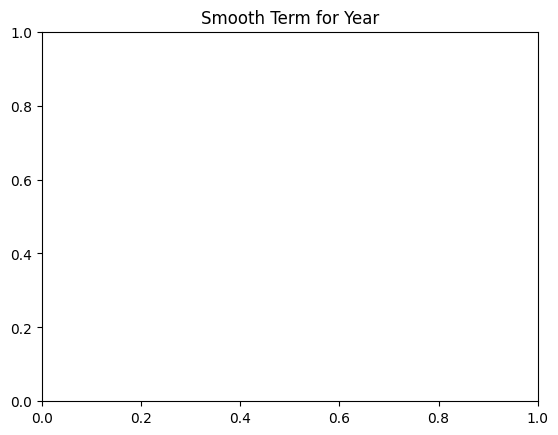

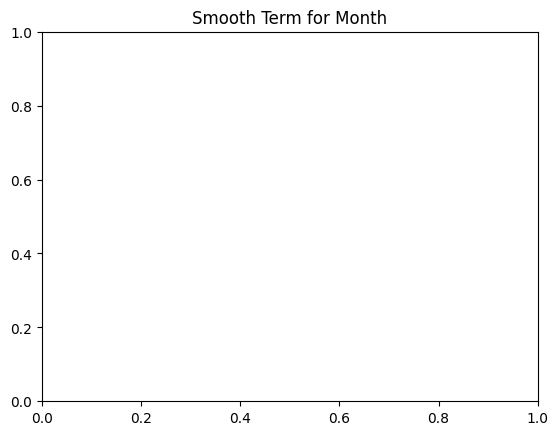

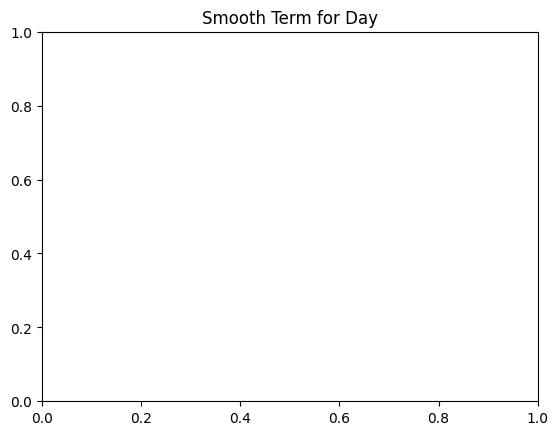

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      21.843
Link Function:                     IdentityLink Log Likelihood:                                 -24855.977
Number of Samples:                         1524 AIC:                                            49757.6401
                                                AICc:                                           49758.3662
                                                GCV:                                          4959722.6452
                                                Scale:                                        4831932.7786
                                                Pseudo R-Squared:                                   0.3663
Feature Function                  Lam

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\3074818017.py:29: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [ ]:
# Define the GAM model with smooth terms for each feature
gam = LinearGAM(s(0) + s(1) + s(2)).fit(x_train, y_train)

# Display model summary
print(gam.summary())

from sklearn.metrics import mean_squared_error

# Make predictions on the test set
y_pred = gam.predict(x_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot smooth terms
for i, term in enumerate(["Year", "Month", "Day"]):
    plt.figure()
    plt.title(f"Smooth Term for {term}")
    gam.partial_dependence(term=i, X=x_test, width=0.95)
    plt.show()

import numpy as np

# Perform grid search for optimal smoothness
gam.gridsearch(x_train, y_train, lam=np.logspace(-3, 3, 11))

# Display the updated summary
print(gam.summary())



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.4162
Link Function:                     IdentityLink Log Likelihood:                                -30943.7164
Number of Samples:                         1906 AIC:                                            61952.2653
                                                AICc:                                           61953.4222
                                                GCV:                                          4620587.0516
                                                Scale:                                        4483702.7938
                                                Pseudo R-Squared:                                   0.3825
Feature Function                  Lam

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1876165514.py:7: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




<Figure size 640x480 with 0 Axes>

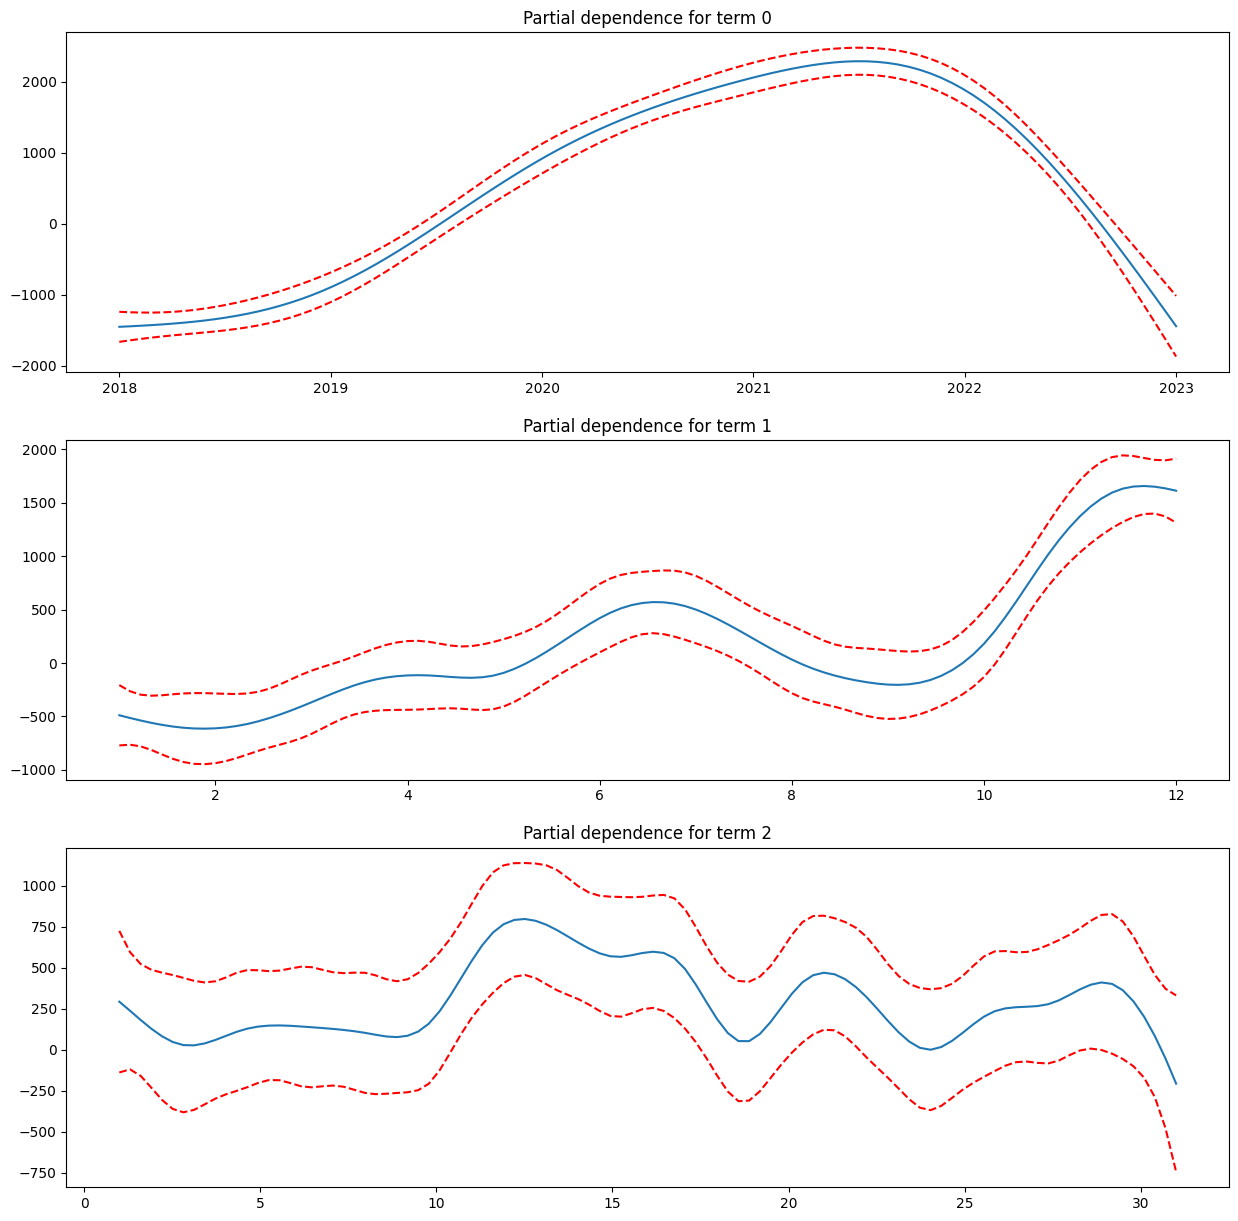

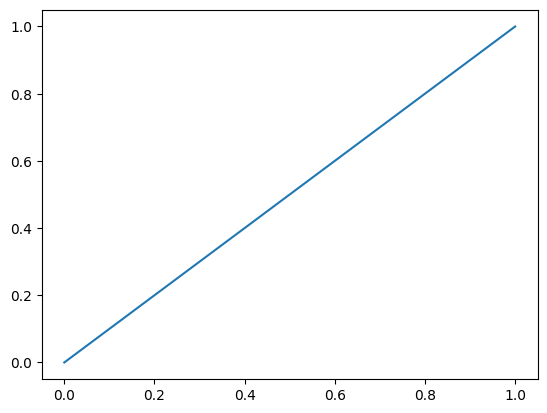

[[2018.            0.            0.        ]
 [2018.05050505    0.            0.        ]
 [2018.1010101     0.            0.        ]
 [2018.15151515    0.            0.        ]
 [2018.2020202     0.            0.        ]
 [2018.25252525    0.            0.        ]
 [2018.3030303     0.            0.        ]
 [2018.35353535    0.            0.        ]
 [2018.4040404     0.            0.        ]
 [2018.45454545    0.            0.        ]
 [2018.50505051    0.            0.        ]
 [2018.55555556    0.            0.        ]
 [2018.60606061    0.            0.        ]
 [2018.65656566    0.            0.        ]
 [2018.70707071    0.            0.        ]
 [2018.75757576    0.            0.        ]
 [2018.80808081    0.            0.        ]
 [2018.85858586    0.            0.        ]
 [2018.90909091    0.            0.        ]
 [2018.95959596    0.            0.        ]
 [2019.01010101    0.            0.        ]
 [2019.06060606    0.            0.        ]
 [2019.111

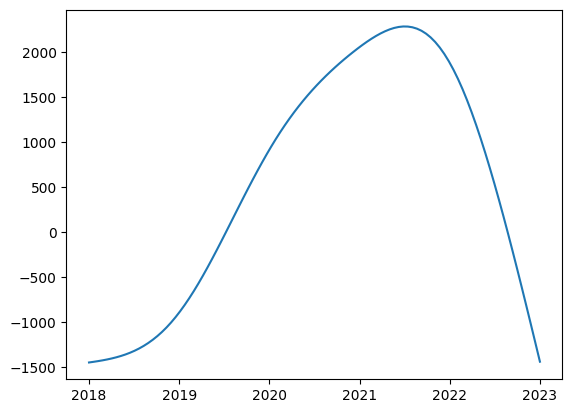

In [81]:
from pygam import LinearGAM

# Assuming gam is your trained LinearGAM model
gam = LinearGAM().fit(x, y)

# Plot partial dependence
gam.summary()  # Summary should list all feature splines

# Plot each term (feature)
import matplotlib.pyplot as plt
plt.figure()
fig, axs = plt.subplots(nrows=3, figsize=(15, 15))  # Adjust nrows to the number of features

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f"Partial dependence for term {i}")
plt.show()

import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1])
plt.show()

XX = gam.generate_X_grid(term=0)
print(XX)
pd = gam.partial_dependence(term=0, X=XX)
plt.plot(XX[:, 0], pd)
plt.show()

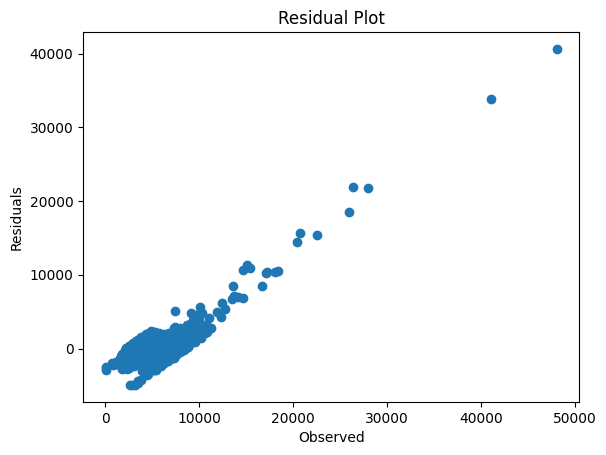

In [74]:
import matplotlib.pyplot as plt

# Residual plot
plt.scatter(y, gam.deviance_residuals(x.iloc[:, :3], y))
plt.xlabel('Observed')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [72]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Select only the first two columns of x_test
x_test_selected = x_test.iloc[:, :3]

y_pred = gam.predict(x_test_selected)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)

R^2: 0.45104611032190933
MAE: 1003.8732605959208
RMSE: 1759.230450995772


In [73]:
x_test_selected

,Year,Month,Day
1226,2021,5,11
111,2018,4,22
1839,2023,1,14
1675,2022,8,3
415,2019,2,20
...,...,...,...
1220,2021,5,5
1834,2023,1,9
733,2020,1,4
584,2019,8,8


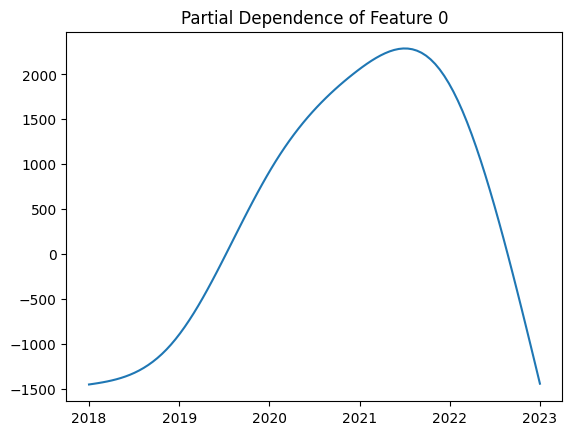

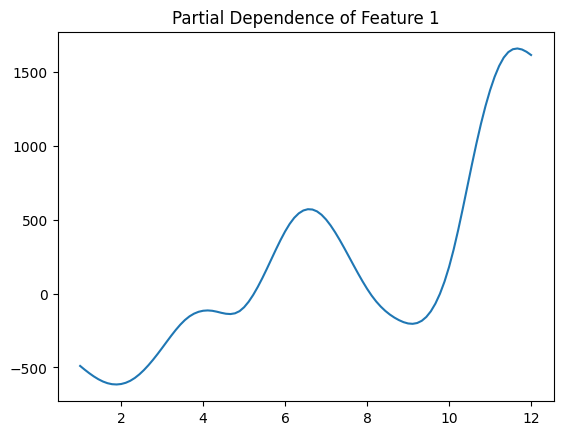

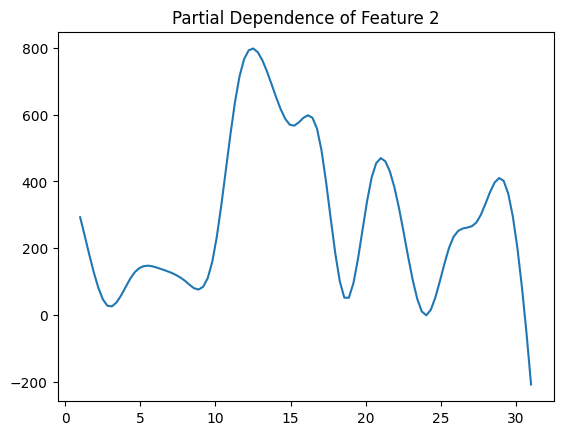

In [76]:
import matplotlib.pyplot as plt
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of Feature {i}")
    plt.show()

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate dates for the next 3 months
future_dates = pd.date_range(start="2024-04-01", end="2024-06-30", freq="D")

# Generate the same features as used in the training data
future_features = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month,
    "Day": future_dates.day
})

# Assume `gam` is your trained LinearGAM model
future_predictions = gam.predict(future_features)

# Get confidence intervals
intervals = gam.prediction_intervals(future_features, width=0.95)
lower = intervals[:, 0]  # Lower bounds
upper = intervals[:, 1]  # Upper bounds

# Plot the results
import plotly.express as px

fig = px.line(x=future_dates, y=future_predictions, labels={'x': 'Date', 'y': 'Revenue'}, title='Predicted Daily Revenue for the Next 3 Months')
fig.add_scatter(x=future_dates, y=lower, mode='lines', line=dict(color='gray'), name='Lower Bound')
fig.add_scatter(x=future_dates, y=upper, mode='lines', line=dict(color='gray'), name='Upper Bound', fill='tonexty')
fig.show()

# Save predictions to a CSV
# predictions_df = pd.DataFrame({
#     "date": future_dates,
#     "predicted_revenue": future_predictions,
#     "lower_bound": lower,
#     "upper_bound": upper
# })
# predictions_df.to_csv("revenue_predictions.csv", index=False)

In [ ]:
from pygam import LinearGAM
import numpy as np

# Perform grid search for optimal smoothness
gam = LinearGAM().gridsearch(x.values, y.values, lam=np.logspace(-3, 3, 11))
gam.summary()

In [ ]:
from pygam import LinearGAM

# Fit the model without the third feature
gam = LinearGAM().fit(x.iloc[:, :2], y)
gam.summary()

In [ ]:
#GAMs
from pygam import LinearGAM, s, f
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import plotly.express as px

In [ ]:
aggregated_data.rename(columns={'Day of Week': 'Weekday', 'Purchase Price Per Unit': 'Revenue'}, inplace=True)
aggregated_data.columns

Index(['Order Date', 'Quantity', 'Revenue', 'Year', 'Month', 'Day', 'Weekday'], dtype='object')

In [ ]:
aggregated_data.head()

,Order Date,Quantity,Revenue,Year,Month,Day,Weekday
0,2018-01-01,139.0,2047.07,2018,1,1,0
1,2018-01-02,122.0,2123.32,2018,1,2,1
2,2018-01-03,96.0,1532.08,2018,1,3,2
3,2018-01-04,137.0,2704.24,2018,1,4,3
4,2018-01-05,98.0,1923.39,2018,1,5,4


In [ ]:
x = aggregated_data[["Year", "Month", "Day"]]
y = aggregated_data["Revenue"]

In [ ]:
x.values

array([[2018,    1,    1],
       [2018,    1,    2],
       [2018,    1,    3],
       ...,
       [2023,    3,   20],
       [2023,    3,   21],
       [2023,    3,   22]])

In [ ]:
# Initialize and fit the model
gam = LinearGAM(s(0) + s(1) + s(2))
gamFit = gam.gridsearch(x.values, y)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


AttributeError: 'csr_matrix' object has no attribute 'A'

In [87]:
aggregated_data.head()

,Order Date,Quantity,Revenue,Year,Month,Day,Day of Week
0,2018-01-01,201.0,3091.23,2018,1,1,0
1,2018-01-02,173.0,2986.71,2018,1,2,1
2,2018-01-03,184.0,3325.05,2018,1,3,2
3,2018-01-04,181.0,3286.29,2018,1,4,3
4,2018-01-05,142.0,3786.45,2018,1,5,4


                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 1906
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -15783.986
Date:                           Thu, 12 Dec 2024   AIC                          31579.973
Time:                                   19:37:22   BIC                          31613.264
Sample:                                        0   HQIC                         31592.229
                                          - 1906                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Quantity      24.5154      0.097    253.884      0.000      24.326      24.705
ar.L1          0.0890      0.019      4.712

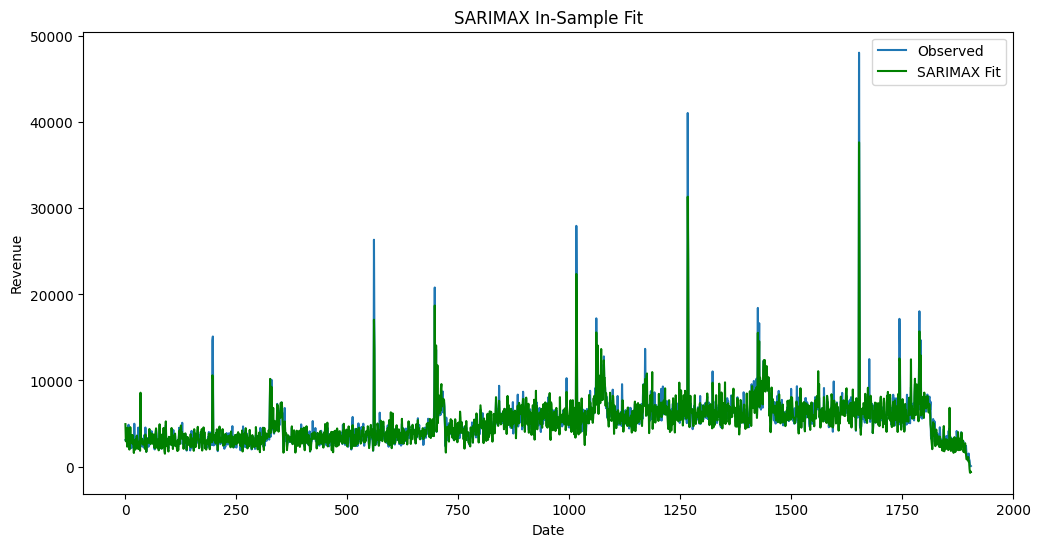

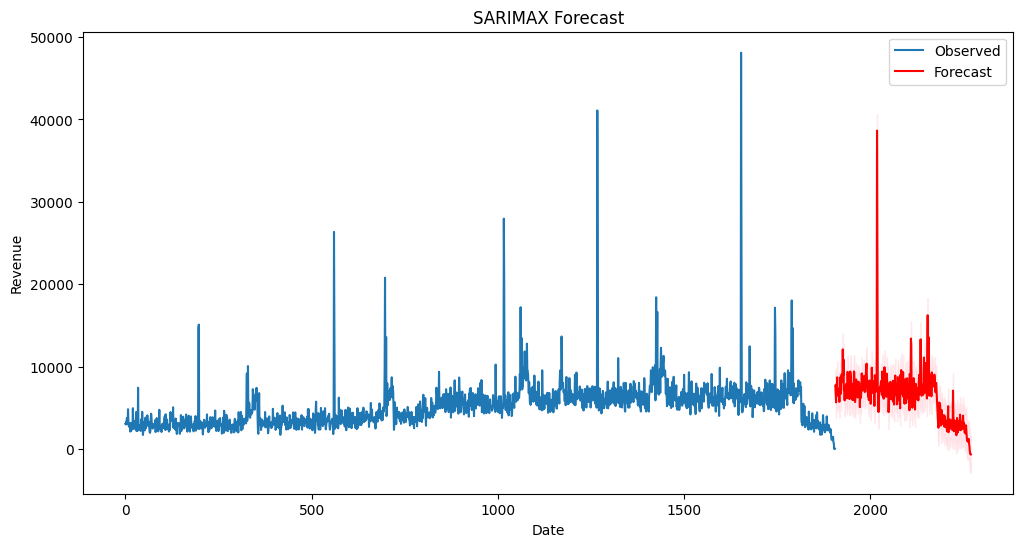

In [92]:
#SARIMAX
# Assuming aggregated_data is already loaded in the notebook
# Ensure the data is sorted by the index
aggregated_data = aggregated_data.sort_index()
aggregated_data.rename(columns={'Day of Week': 'Weekday'}, inplace=True)

# Fit SARIMAX Model
model = SARIMAX(aggregated_data["Revenue"], 
                order=(1, 1, 1),  # p, d, q
                seasonal_order=(1, 1, 1, 7),  # P, D, Q, s
                exog=aggregated_data[["Quantity"]])  # Exogenous variable
result = model.fit()

# Summary of the model
print(result.summary())

# Generate in-sample predictions
in_sample_predictions = result.predict(start=0, end=len(aggregated_data)-1, exog=aggregated_data[["Quantity"]])

# Forecast steps
days_in_month = 365 / 12
forecast_steps = int(12 * days_in_month)  # Forecast for 12 months

# Assuming you have future exogenous variables for the forecast period
# If not, you can use the last available exogenous variables or create a placeholder
exog_forecast = aggregated_data[["Quantity"]].iloc[-forecast_steps:].copy()

# Forecast
forecast = result.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the original data and the SARIMAX in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(in_sample_predictions, label="SARIMAX Fit", color='green')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX In-Sample Fit')
plt.legend()
plt.show()

# Plot the original data and the SARIMAX forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(forecast_values, label="Forecast", color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

In [ ]:
# Calculate accuracy metrics
mae = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

avg_revenue = aggregated_data["Revenue"].mean()
print(f"Average Revenue: {avg_revenue:.2f}")
print(f"MAE as % of Avg Revenue: {mae / avg_revenue * 100:.2f}%")
print(f"RMSE as % of Avg Revenue: {rmse / avg_revenue * 100:.2f}%")

# Train Models

In [ ]:
#Decision Tree

# Create the model and fit it
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(x, y)

DecisionTreeClassifier(max_depth=5)

# Prediction & Validation

In [ ]:
#Decision Tree "clf"

print("\n\nIn-sample accuracy: %s%%\n\n" 
 % str(round(100*accuracy_score(y, clf.predict(x)), 2)))
print("\n\nOut-of-sample accuracy: %s%%\n\n"
%str(round(100*accuracy_score(yt, clf.predict(xt)), 2)))



In-sample accuracy: 86.96%




Out-of-sample accuracy: 87.02%


